## Setup

In [1]:
import outlaw.nb_util as util

util.setup_nb()

In [2]:
import outlaw.berry as berry
import outlaw.quad as quad
import outlaw.inla as inla
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Run Outlaw hyperparameter posterior

In [3]:
dtype = np.float64
# data = berry.figure1_data(N=1)[0].astype(dtype)
data = berry.figure2_data(N=1)[0].astype(dtype)
sig2_rule = quad.log_gauss_rule(70, 1e-6, 1e3)
# sig2_rule = quad.log_gauss_rule(70, 1e-3, 1e3)
sig2 = sig2_rule.pts
# sig2_df = pd.DataFrame(dict(theta=sig2_rule.pts, wts=sig2_rule.wts))
# sig2_df.to_csv('sig2_rule.csv', index=False)

In [4]:
inla_ops = berry.optimized(sig2, dtype=dtype).config(max_iter=20, opt_tol=dtype(1e-9))

logpost, x_max, hess_info, iters = jax.jit(inla_ops.laplace_logpost)(
    np.zeros((sig2.shape[0], 4), dtype=dtype), dict(sig2=sig2), data
)
post = inla.exp_and_normalize(logpost, sig2_rule.wts.astype(dtype), axis=0)

## Compare conditional modes

In [5]:
import jax.numpy as jnp


def get_mode(sigv):
    sig2 = jnp.array([sigv])
    inla_ops = berry.optimized(sig2, dtype=dtype).config(
        max_iter=20, opt_tol=dtype(1e-9)
    )
    logpost, x_max, hess, iters = jax.jit(inla_ops.laplace_logpost)(
        np.zeros((sig2.shape[0], 4), dtype=dtype), dict(sig2=sig2), data
    )
    return logpost, x_max + berry.logit_p1


mode_logpost, x_mode = get_mode(2.450777)
rinla_mode = np.array(
    [-3.50623749537295, -2.70361459031453, -1.12019680920479, -0.97990490388751]
)
print(rinla_mode)
print(x_mode[0])
print(rinla_mode - x_mode)

[-3.5062375  -2.70361459 -1.12019681 -0.9799049 ]
[-3.50623784 -2.70361474 -1.12019645 -0.97990449]
[[ 3.48965332e-07  1.49408818e-07 -3.62057242e-07 -4.16555661e-07]]


## Compare hyperparameter posteriors

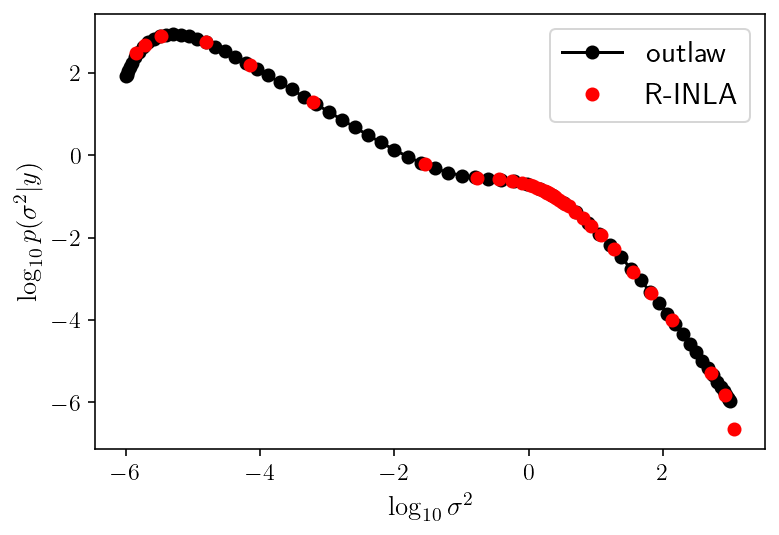

In [6]:
rinla_df = pd.read_csv("hyperpar_data2.csv")
# rinla_sig2 = 1.0 / rinla_df['x'].to_numpy()
# rinla_post = (rinla_df['y'] / rinla_sig2 ** 2).to_numpy()
rinla_sig2 = 1.0 / np.exp(rinla_df["x"]).to_numpy()
rinla_post = (rinla_df["y"] / rinla_sig2**1).to_numpy()

plt.plot(np.log10(sig2), np.log10(post), "k-o", label="outlaw")
plt.plot(np.log10(rinla_sig2), np.log10(rinla_post), "ro", label="R-INLA")
plt.xlabel("$\log_{10} \sigma^2$")
plt.ylabel("$\log_{10} p(\sigma^2 | y)$")
plt.legend()
plt.show()

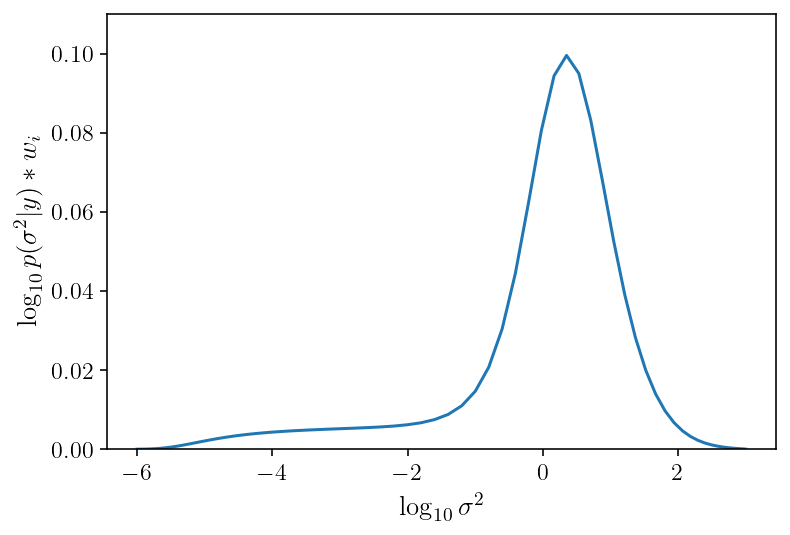

In [7]:
plt.plot(np.log10(sig2), post * sig2_rule.wts)
plt.xlabel("$\log_{10} \sigma^2$")
plt.ylabel("$\log_{10} p(\sigma^2 | y) * w_i$")
plt.ylim([0, 0.11])
plt.show()

## Multi-compare hyperparameters

skipping 1e-06


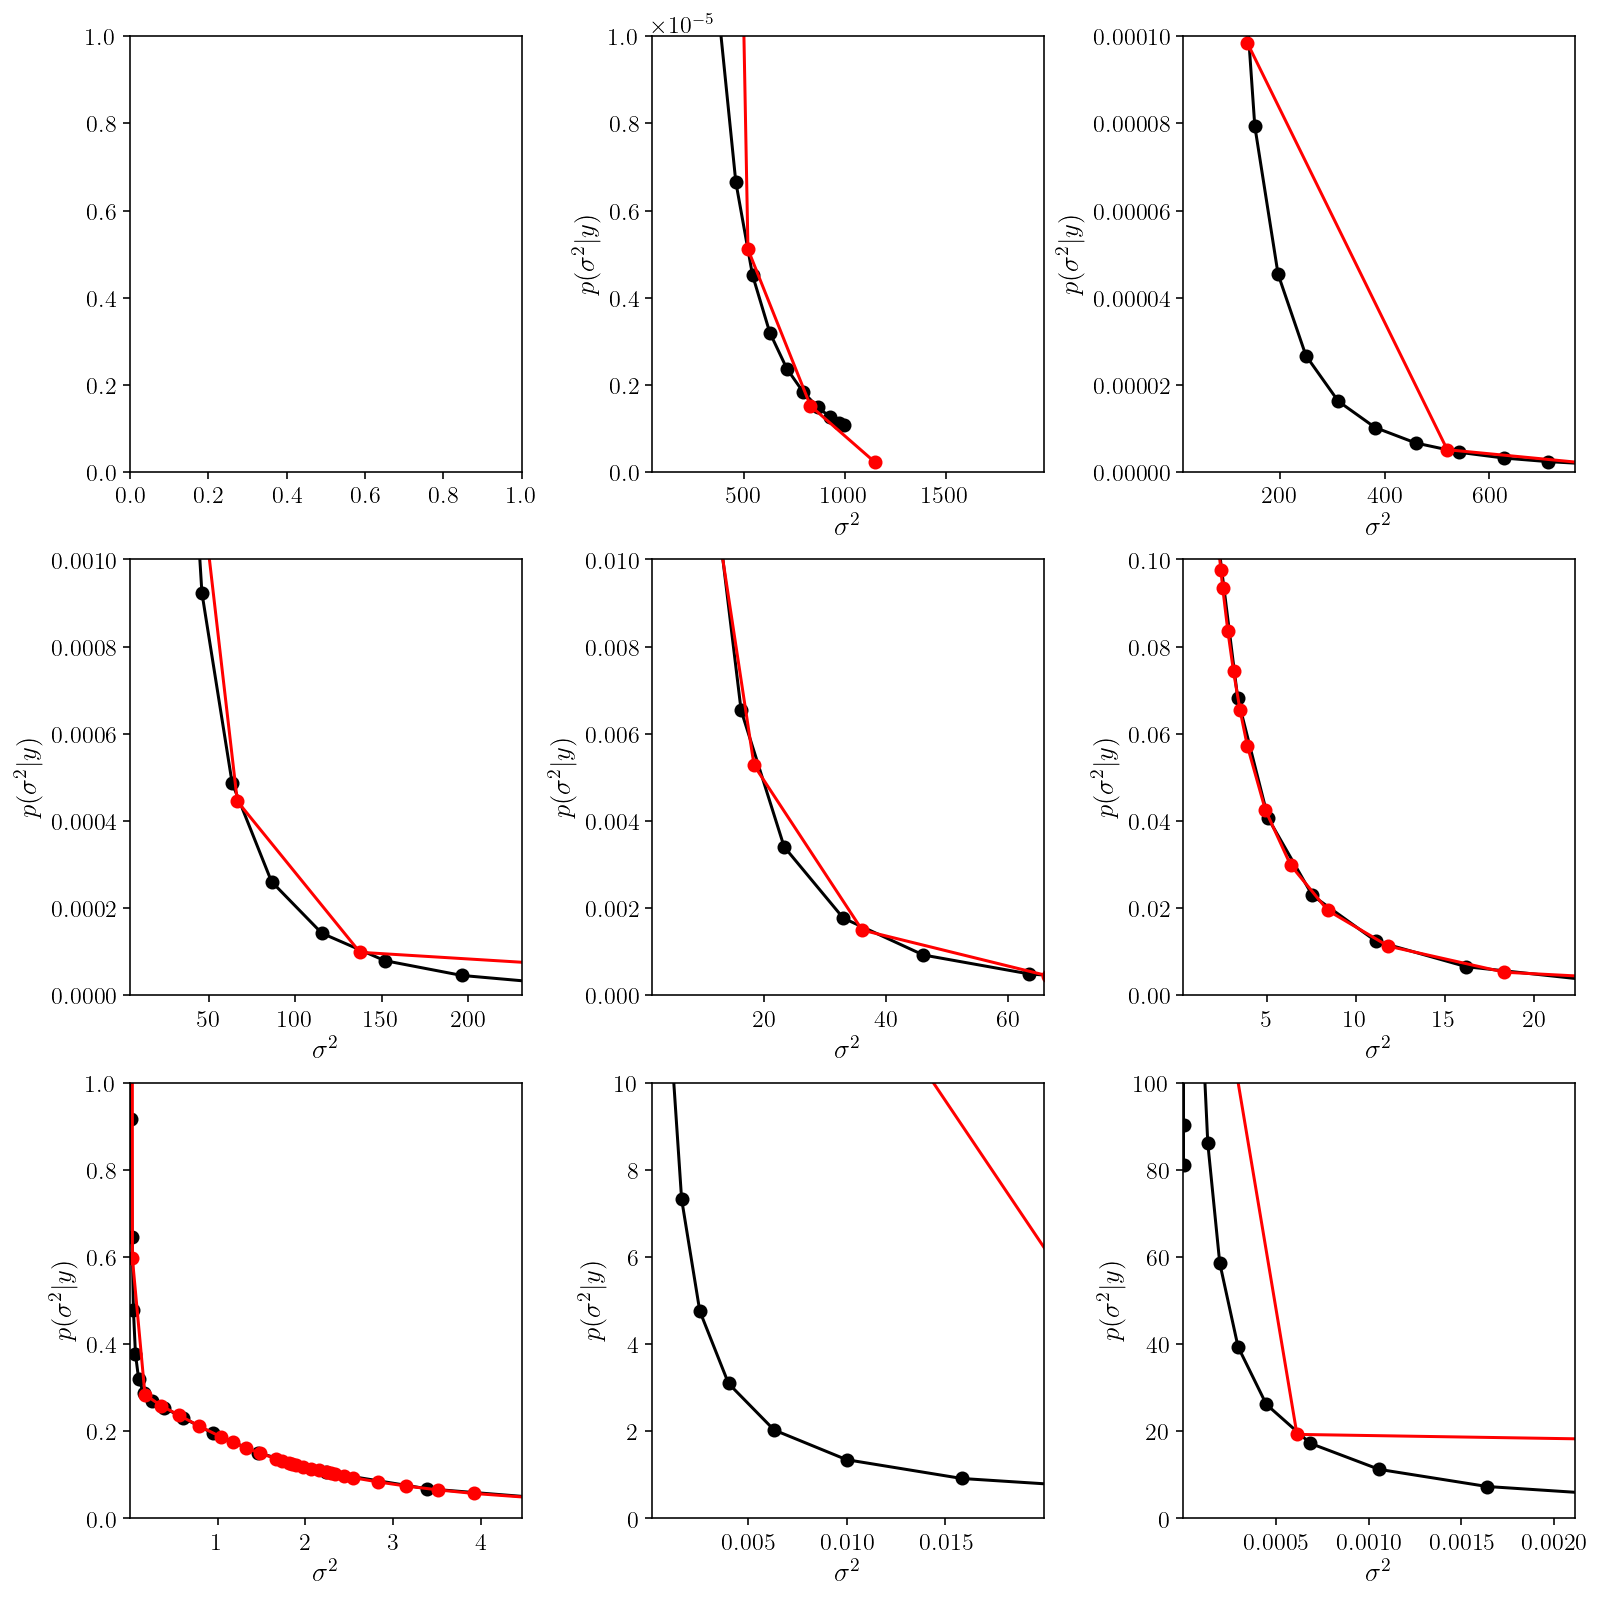

In [8]:
plt.figure(figsize=(11, 11), constrained_layout=True)
for i, upper in enumerate(10.0 ** np.arange(-6, 3)):
    plt.subplot(3, 3, i + 1)
    relevant_pts = (post < upper) & (post > upper * 0.1)
    if relevant_pts.sum() == 0:
        print("skipping", upper)
        continue
    xlim = [0.1 * np.min(sig2[relevant_pts]), np.max(sig2[relevant_pts]) * 2]
    plt.plot(sig2, post, "k-o", label="outlaw")
    plt.plot(rinla_sig2, rinla_post, "r-o", label="R-INLA")
    plt.xlabel("$\sigma^2$")
    plt.ylabel("$p(\sigma^2 | y)$")
    plt.xlim(xlim)
    plt.ylim([0, upper])
    if i == 0:
        plt.legend()
plt.show()

## Compute conditional latent posteriors

In [9]:
arm_logpost_f = jax.jit(
    jax.vmap(
        inla_ops.cond_laplace_logpost,
        in_axes=(None, None, None, None, 0, None, None),
    ),
    static_argnums=(5, 6),
)
invv = jax.jit(jax.vmap(inla_ops.invert))

inv_hess = invv(hess_info)
arm_idx = 0
cx, wts = inla.gauss_hermite_grid(x_max, inv_hess[..., arm_idx, :], arm_idx, n=25)
# cx, wts = inla.latent_grid(
#     x_max, inv_hess[..., arm_idx, :], arm_idx,
#     quad.gauss_rule(105, a=-5, b=5)
# )
cx = cx[:, 0]
wts = wts[:, 0]

arm_logpost = arm_logpost_f(
    x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2, theta=None), data, cx, arm_idx, True
)
arm_post = inla.exp_and_normalize(arm_logpost, wts, axis=0)

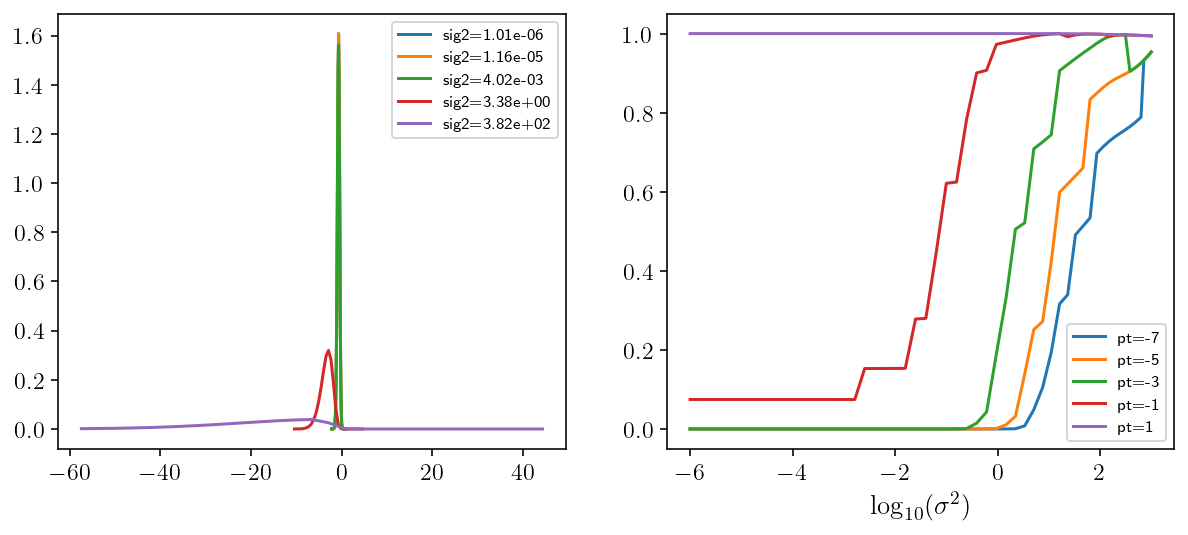

In [10]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
for i in range(0, sig2_rule.pts.shape[0], 15):
    plt.plot(cx[:, i], arm_post[:, i], label="sig2={:.2e}".format(sig2_rule.pts[i]))
plt.legend(fontsize=8)
plt.subplot(1, 2, 2)
for pt in [-7, -5, -3, -1, 1]:
    include = cx < pt
    x_integral = jnp.trapz(arm_post * include, x=cx, axis=0)
    plt.plot(np.log10(sig2_rule.pts), x_integral, label="pt={}".format(pt))
plt.xlabel("$\log_{10}(\sigma^2)$")
plt.legend(fontsize=8)
plt.show()

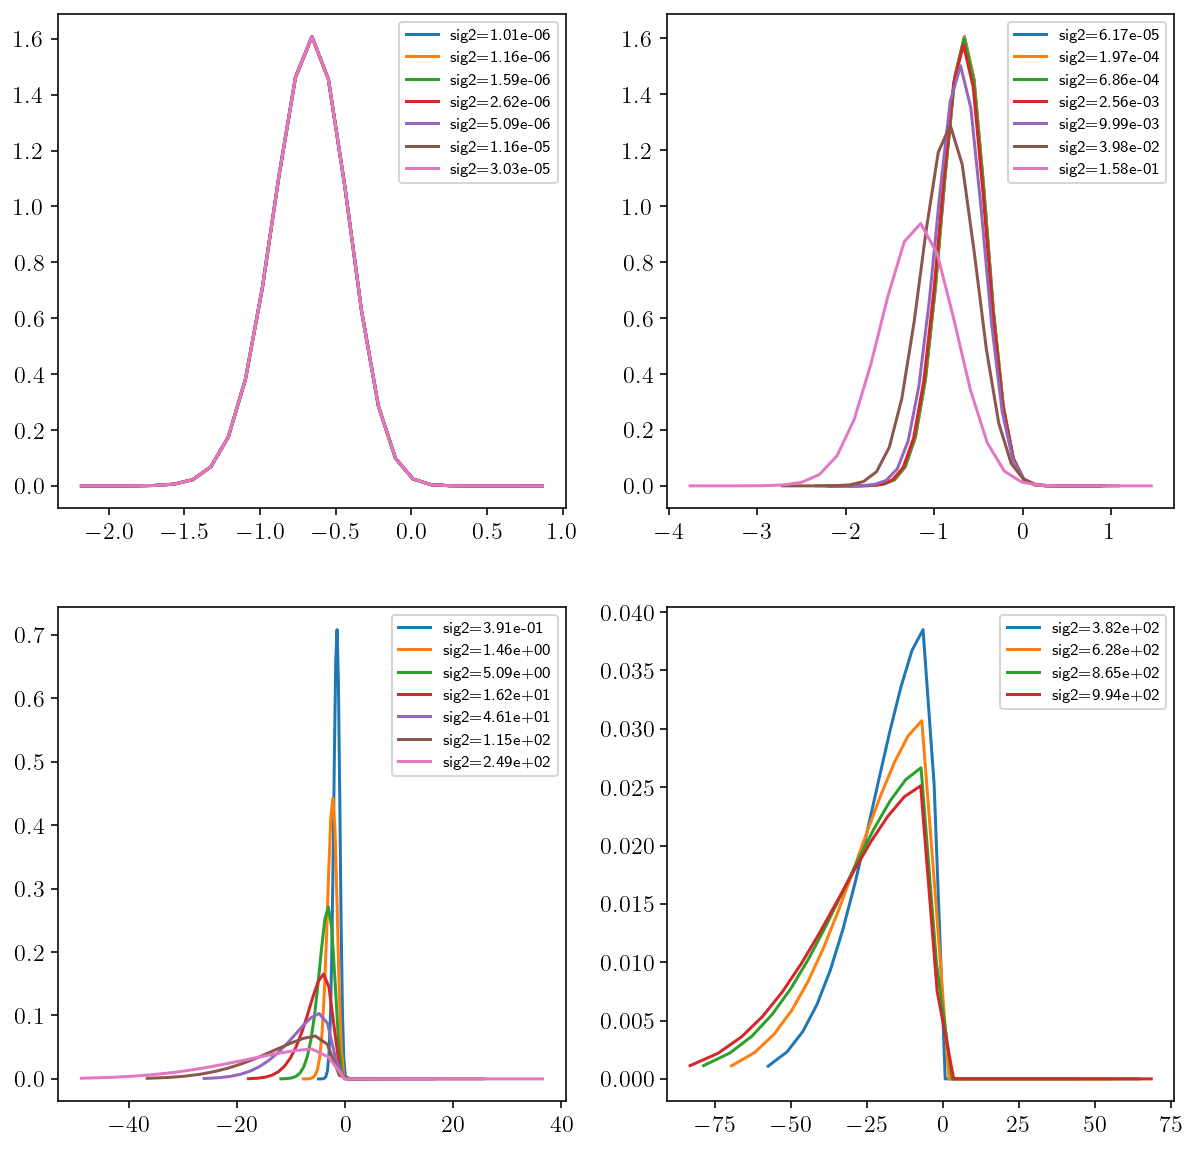

In [11]:
group_size = 20
plt.figure(figsize=(10, 10))
for subplot_idx, i0 in enumerate(range(0, sig2_rule.pts.shape[0], group_size)):
    plt.subplot(2, 2, subplot_idx + 1)
    for i in range(i0, min(sig2_rule.pts.shape[0], i0 + group_size), 3):
        plt.plot(cx[:, i], arm_post[:, i], label="sig2={:.2e}".format(sig2_rule.pts[i]))
    plt.legend(fontsize=8)
    # plt.xlim([-10, 1])
plt.show()

## Compute unconditional latent posteriors - exceedance derivative.

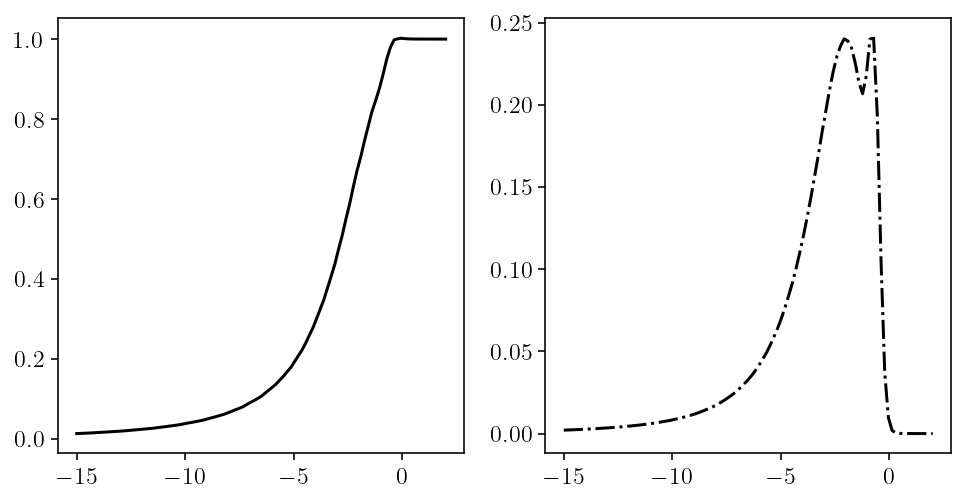

In [12]:
arm_quad = quad.simpson_rule(101, -15, 2)
interp_vmap = jax.vmap(lambda *args: jnp.interp(*args, 0, 0), in_axes=(None, 1, 1))


def unconditional(pt):
    include = cx < pt
    x_integral = jnp.trapz(arm_post * include, x=cx, axis=0)

    first_above = jnp.argmin(include, axis=0)
    y_last_below = arm_post[first_above - 1, jnp.arange(sig2_rule.pts.shape[0])]
    x_last_below = cx[first_above - 1, jnp.arange(sig2_rule.pts.shape[0])]
    interp = interp_vmap(pt, cx, arm_post).T
    x_integral += jnp.trapz(
        # jnp.array([jnp.zeros_like(interp), interp]),
        jnp.array([y_last_below, interp]),
        jnp.array([x_last_below, jnp.full_like(x_last_below, pt)]),
        axis=0,
    )

    return jnp.where(
        jnp.any(include), jnp.sum(x_integral * post * sig2_rule.wts, axis=0), 0
    )


uncon_cdf = jax.vmap(unconditional)(arm_quad.pts)
uncon_pdf_exceedance = jax.vmap(jax.grad(unconditional))(arm_quad.pts)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(arm_quad.pts, uncon_cdf, "k-")
plt.subplot(1, 2, 2)
plt.plot(arm_quad.pts, uncon_pdf_exceedance, "k-.")
plt.show()

## Compute unconditional latent posteriors - interpolation

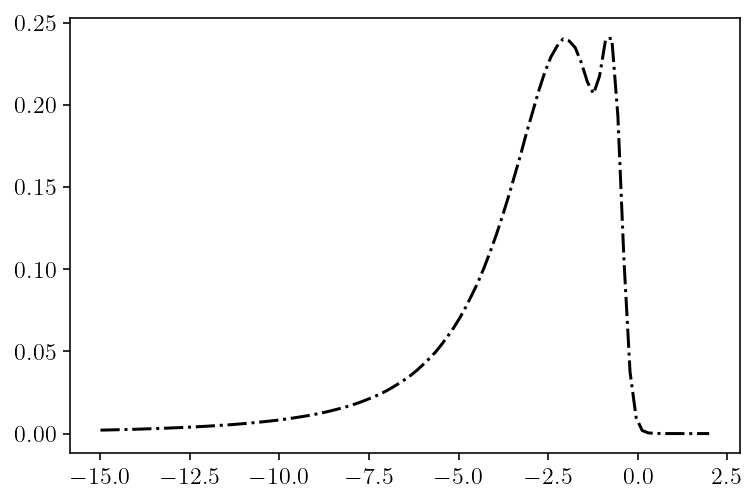

In [13]:
interp_vmap = jax.vmap(lambda *args: jnp.interp(*args, 0, 0), in_axes=(None, 1, 1))
interp_marg_condsig2 = interp_vmap(arm_quad.pts, cx, arm_post).T
uncon_pdf_interp = np.sum(interp_marg_condsig2 * post * sig2_rule.wts, axis=1)
plt.plot(arm_quad.pts, uncon_pdf_interp, "k-.")
plt.show()

## Compute unconditional latent posteriors - fixed grid

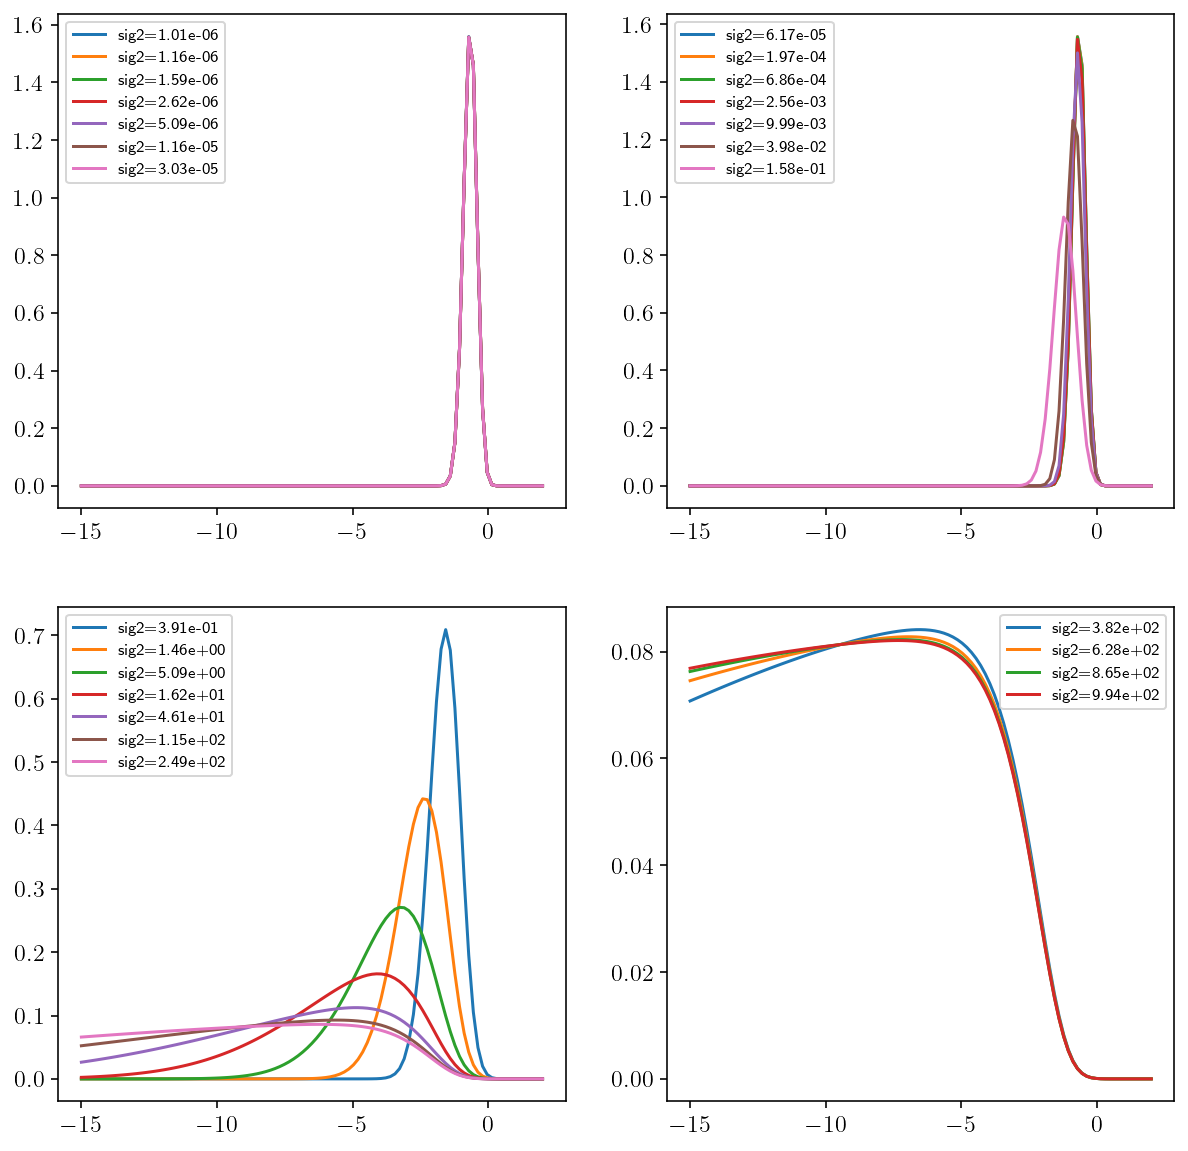

In [14]:
arm_idx = 0
inv_hess = jax.vmap(inla_ops.invert)(hess_info)

cx = np.tile(arm_quad.pts[:, None], (1, sig2.shape[0]))
wts = np.tile(arm_quad.wts[:, None], (1, sig2.shape[0]))
cond_laplace_f = jax.vmap(
    lambda *args: inla_ops.cond_laplace_logpost(*args, reduced=True),
    in_axes=(None, None, None, None, 0, None),
)
logpost_arm = cond_laplace_f(
    x_max, inv_hess[:, :, arm_idx], dict(sig2=sig2), data, cx, arm_idx
)
arm_post = inla.exp_and_normalize(logpost_arm, wts, axis=0)

group_size = 20
plt.figure(figsize=(10, 10))
for subplot_idx, i0 in enumerate(range(0, sig2_rule.pts.shape[0], group_size)):
    plt.subplot(2, 2, subplot_idx + 1)
    for i in range(i0, min(sig2_rule.pts.shape[0], i0 + group_size), 3):
        plt.plot(cx[:, i], arm_post[:, i], label="sig2={:.2e}".format(sig2_rule.pts[i]))
    plt.legend(fontsize=8)
    # plt.xlim([-10, 1])
plt.show()

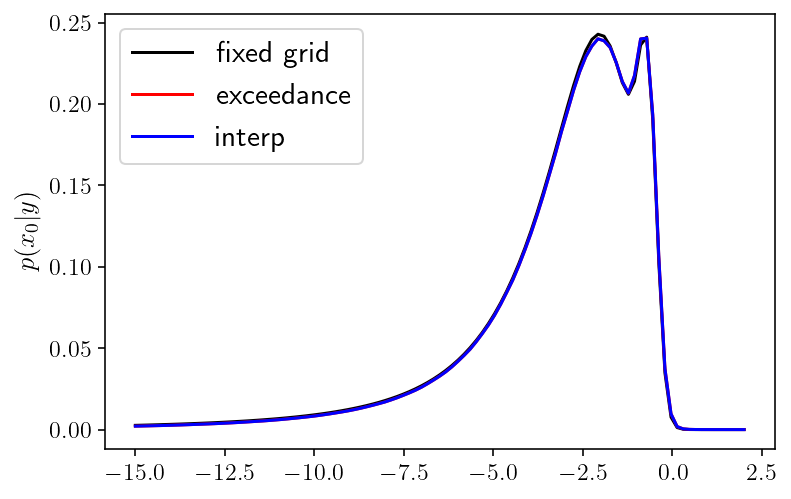

In [15]:
uncon_pdf_fixed = np.sum(arm_post * post * sig2_rule.wts, axis=1)
plt.plot(arm_quad.pts, uncon_pdf_fixed, "k-", label="fixed grid")
plt.plot(arm_quad.pts, uncon_pdf_exceedance, "r-", label="exceedance")
plt.plot(arm_quad.pts, uncon_pdf_interp, "b-", label="interp")
plt.legend()
plt.ylabel("$p(x_0|y)$")
plt.show()

## Gaussian latent marginals

In [16]:
theta_sigma = np.sqrt(np.diagonal(-inv_hess, axis1=1, axis2=2))
theta_mu = x_max
uncon_pdf_gaussian = np.sum(
    scipy.stats.norm.pdf(
        arm_quad.pts[:, None],
        theta_mu[None, :, arm_idx],
        theta_sigma[None, :, arm_idx],
    )
    * post
    * sig2_rule.wts,
    axis=1,
)

## Compare latent marginals

In [17]:
import berrylib.mcmc as mcmc

data = berry.figure2_data(N=1)[0].astype(np.float32)
mcmc_results = mcmc.mcmc_berry(data[None], n_samples=int(1000000))

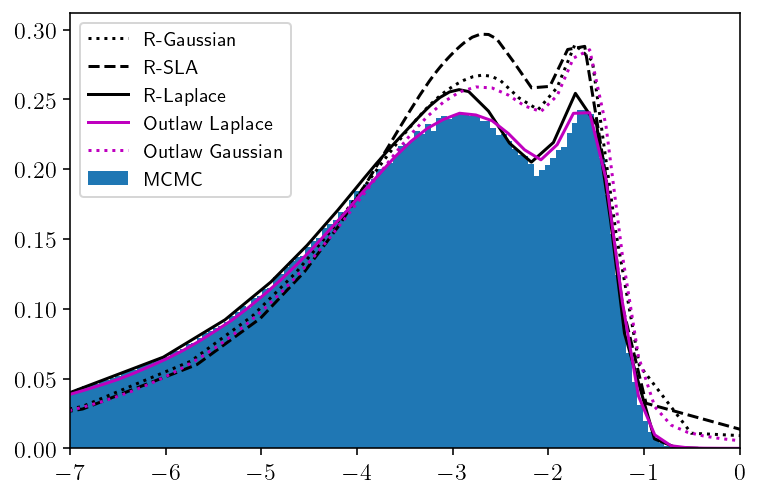

In [19]:
rinla_latent = pd.read_csv("latent_data.csv")
for i, strategy in enumerate(rinla_latent["strategy"].unique()):
    strat_name = {
        "gaussian": "Gaussian",
        "laplace": "Laplace",
        "simplified.laplace": "SLA",
    }[strategy]
    subset_df = rinla_latent.loc[rinla_latent["strategy"] == strategy]
    plt.plot(
        subset_df["x"] + berry.mu_0 + berry.logit_p1,
        subset_df["y"],
        color="k",
        linestyle=["dotted", "dashed", "solid"][i],
        label="R-" + strat_name,
    )
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_interp,
    color="m",
    linestyle="solid",
    label="Outlaw Laplace",
)
plt.plot(
    arm_quad.pts + berry.logit_p1,
    uncon_pdf_gaussian,
    color="m",
    linestyle="dotted",
    label="Outlaw Gaussian",
)
plt.hist(
    mcmc_results["x"][0]["theta"][0, :, 0] + berry.logit_p1,
    bins=np.linspace(-15, 2, 300),
    density=True,
    label="MCMC",
)
plt.xlim([-7, 0])
plt.legend(fontsize=10)
plt.show()

## extra

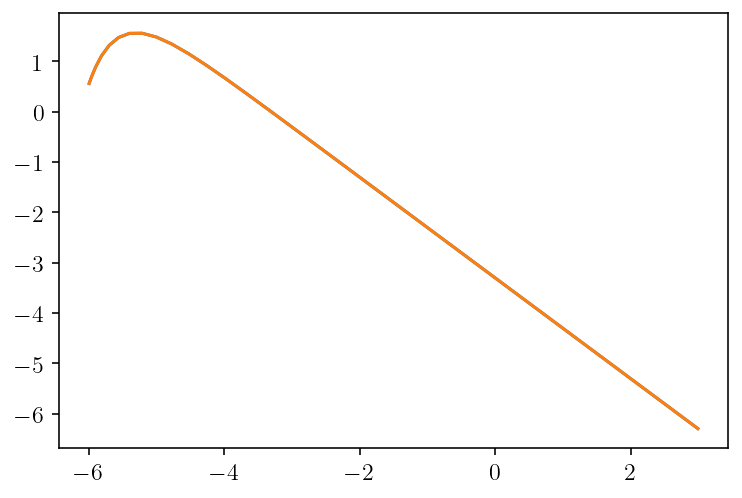

In [21]:
sig2 = sig2_rule.pts
sig2_alpha = 0.0005
sig2_beta = 0.000005
invg_pdf = scipy.stats.invgamma.pdf(sig2, sig2_alpha, scale=sig2_beta)
g_pdf = scipy.stats.gamma.pdf(sig2, sig2_alpha, scale=(1.0 / sig2_beta) * (sig2**2))
plt.plot(np.log10(sig2), np.log10(invg_pdf))
plt.plot(np.log10(sig2), np.log10(g_pdf))
plt.show()

In [ ]:
# numdifftools can be really handy for computing higher order derivatives
# numerically!
def joint_at_max(x):
    return inla_ops.log_jointv(x_max + x, None, data)[-1]


import numdifftools

for step in [0.01, 0.1, 1.0]:
    H = numdifftools.Hessian(joint_at_max, step)(np.zeros(4, dtype=dtype))
    print(step, np.linalg.slogdet(H)[1])

0.01 -1.0999984915225336
0.1 -1.0960460181310459
1.0 -0.7511898094989797
